<a href="https://colab.research.google.com/github/timlok123/PHYS3151-Machine-Learning-in-Physics-2025/blob/main/multivariate-linear-regression/2D_function_expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using linear regression to fit a 2-dimensional function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random

Consider a 2-dimensional function $\cos(x^2+y^2)$ in the domain $(x,y)\in [-1,1]^2$. In the following sections, we are going to fit it with polynomials of $x$ and $y$. Let's take a look.

In [ ]:
def test_func(x, y):
    return np.cos(x**2+y**2)

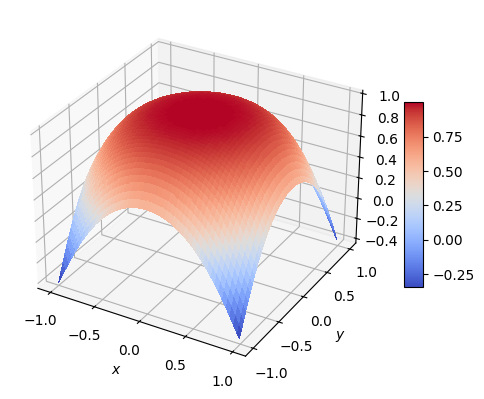

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Make data.
X = np.arange(-1, 1, 0.01)
Y = np.arange(-1, 1, 0.01)

X, Y = np.meshgrid(X, Y)
Z = test_func(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
cset = ax.contour(X, Y, Z, zdir='z', offset=-4, cmap=cm.coolwarm)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

First, we randomly sample some data points from the graph, and save them for future fitting.

In [ ]:
random.seed
with open('test_func_data.csv', mode='w') as sample_file:
    gravity_writer = csv.writer(sample_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    gravity_writer.writerow(['f(x,y)','x', 'y'])
    for i in range (0, 200):
        x = random.uniform(-1,1)
        y = random.uniform(-1,1)
        gravity_writer.writerow([test_func(x, y), x, y])

In [ ]:
df = pd.read_csv('/content/test_func_data.csv')
print(df)

       f(x,y)         x         y
0    0.625800 -0.930903 -0.167509
1    0.867551  0.691690 -0.205191
2    0.869761 -0.237632 -0.677945
3    0.870664  0.530220 -0.482818
4    0.512691 -0.982634  0.258672
..        ...       ...       ...
195  0.324635  0.501842  0.994145
196  0.938175 -0.579571 -0.132565
197  0.398001 -0.554882 -0.923886
198  0.407186 -0.942310  0.513300
199  0.545577 -0.707560  0.702195

[200 rows x 3 columns]


First we try the ansatz $f(x,y)=c_{0,0}+c_{1,0}x+c_{0,1}y+c_{2,0}x^2+c_{0,2}y^2+c_{3,0}x^3+c_{0,3}y^3$, and find all $c_{m,n}$ using gradient descent.

In [ ]:
df['x^2']=df['x']**2
df['y^2']=df['y']**2
df['x^3']=df['x']**3
df['y^3']=df['y']**3
print(df)

       f(x,y)         x         y       x^2       y^2       x^3       y^3
0    0.625800 -0.930903 -0.167509  0.866581  0.028059 -0.806702 -0.004700
1    0.867551  0.691690 -0.205191  0.478435  0.042103  0.330929 -0.008639
2    0.869761 -0.237632 -0.677945  0.056469  0.459610 -0.013419 -0.311590
3    0.870664  0.530220 -0.482818  0.281133  0.233113  0.149062 -0.112551
4    0.512691 -0.982634  0.258672  0.965569  0.066911 -0.948800  0.017308
..        ...       ...       ...       ...       ...       ...       ...
195  0.324635  0.501842  0.994145  0.251845  0.988325  0.126387  0.982539
196  0.938175 -0.579571 -0.132565  0.335902  0.017573 -0.194679 -0.002330
197  0.398001 -0.554882 -0.923886  0.307894  0.853566 -0.170845 -0.788598
198  0.407186 -0.942310  0.513300  0.887949  0.263477 -0.836723  0.135242
199  0.545577 -0.707560  0.702195  0.500641  0.493077 -0.354234  0.346236

[200 rows x 7 columns]


In [ ]:
df = df.to_numpy()
x = df[:,1:7]
y = [df[:,0]]
x = np.array(x)
print(x)
y = np.array(y)
y = y.T
#print(y)

[[-0.93090307 -0.16750851  0.86658053  0.0280591  -0.80670248 -0.00470014]
 [ 0.69169013 -0.20519112  0.47843524  0.0421034   0.33092894 -0.00863924]
 [-0.23763215 -0.67794538  0.05646904  0.45960993 -0.01341886 -0.31159043]
 ...
 [-0.55488163 -0.92388642  0.30789362  0.85356611 -0.17084451 -0.78859813]
 [-0.94231021  0.51329967  0.88794853  0.26347656 -0.83672297  0.13524243]
 [-0.70756011  0.7021947   0.50064131  0.4930774  -0.35423382  0.34623634]]


We define the cost function $J(\Theta)$
$$J(\Theta)=\frac{1}{2M}\sum_{i=1}^M(\textbf{x}^{(i)}\cdotθ-y^{(i)})^2=\frac{1}{2M}||X\Theta-Y||^2$$
and its gradient is
$$\nabla_{\Theta}J(\Theta)=\frac{1}{M}X^{T}(X\Theta-Y)$$
where $\Theta$ is a vector with dimension being the same as the number of fitting terms including the bias term ($N+1$), and $X$ is the $M\times(N+1)$ data matrix.

In [ ]:
def  computeCost(theta,X,y):
    m = float(len(y))
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum(np.square(predictions-y))
    return cost

In [ ]:
def gradient_descent(X,y,theta,alpha,iterations):
    m = float(len(y))
    N=np.size(X,1)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,N))
    for it in range(iterations):

        prediction = np.dot(X,theta)
        theta = theta -(1/m)*alpha*( X.T.dot((prediction - y)))
        theta_history[it,:] = theta.T
        cost_history[it]  = computeCost(theta,X,y)

    return theta, cost_history, theta_history

3.969258810799686
[[ 1.12773505]
 [ 0.02396604]
 [-0.0105282 ]
 [-0.5959451 ]
 [-0.62252412]
 [-0.07043951]
 [ 0.00743183]]
Final cost/MSE:  0.002


Text(0.5, 1.0, 'Cost function using Gradient Descent')

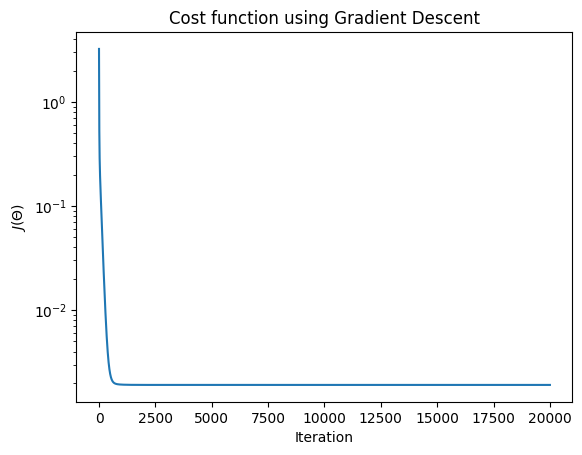

In [ ]:
alpha =0.1
n_iter = 20000
N=np.size(x,1)
theta = np.random.randn(N+1,1)
#print(theta)
x_b = np.c_[np.ones((len(x),1)),x]
#print(x_b)
print(computeCost(theta,x_b,y))

theta,cost_history,theta_history = gradient_descent(x_b,y,theta,alpha,n_iter)

print(theta)
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

plt.plot(cost_history)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

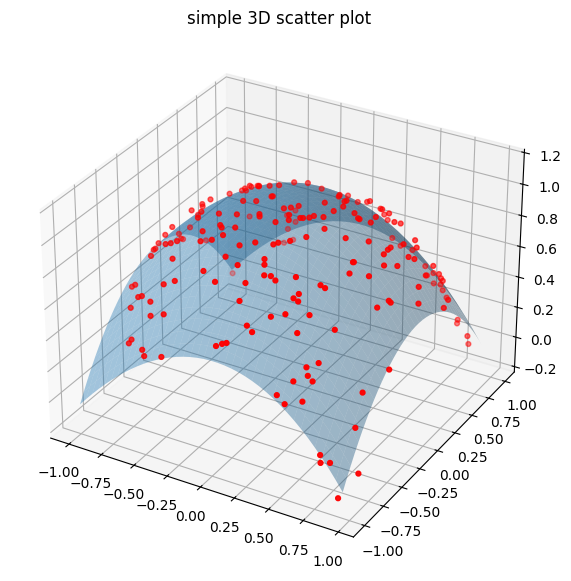

In [ ]:
[XX,YY]=np.meshgrid(df[:,1],df[:,2])
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = theta[0]+theta[1]*X+theta[2]*Y+theta[3]*X**2+theta[4]*Y**2+theta[5]*X**3+theta[6]*Y**3

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                        antialiased=True, alpha=0.4)
# Creating plot
ax.scatter3D(df[:,1],df[:,2],test_func(df[:,1],df[:,2]), color = "red", s=12, label='data sample')
plt.title("simple 3D scatter plot")
# show plot
plt.show()

As can see in the final result of $\Theta$, the zero order term (bias term) has value close to 1, which is $f(0,0)$. \\
Also, only the coefficients in second order terms of $x$ and $y$ and the constant term are significant, while the others are 2 order of magnitude lower than them. That is as excepted, since $\cos(x^2+y^2)$ is even in $x$ and $y$.  Therefore any surviving term should have even orders in both $x$ and $y$.

In [ ]:
df = pd.read_csv('/content/test_func_data.csv')
#print(df)

In [ ]:
df['x^2']=df['x']**2
df['y^2']=df['y']**2
df['x^4']=df['x']**4
df['y^4']=df['y']**4
df['x^2*y^2']=df['x']**2*df['y']**2
print(df)

       f(x,y)         x         y       x^2       y^2       x^4       y^4  \
0    0.625800 -0.930903 -0.167509  0.866581  0.028059  0.750962  0.000787   
1    0.867551  0.691690 -0.205191  0.478435  0.042103  0.228900  0.001773   
2    0.869761 -0.237632 -0.677945  0.056469  0.459610  0.003189  0.211241   
3    0.870664  0.530220 -0.482818  0.281133  0.233113  0.079036  0.054342   
4    0.512691 -0.982634  0.258672  0.965569  0.066911  0.932323  0.004477   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.324635  0.501842  0.994145  0.251845  0.988325  0.063426  0.976786   
196  0.938175 -0.579571 -0.132565  0.335902  0.017573  0.112830  0.000309   
197  0.398001 -0.554882 -0.923886  0.307894  0.853566  0.094798  0.728575   
198  0.407186 -0.942310  0.513300  0.887949  0.263477  0.788453  0.069420   
199  0.545577 -0.707560  0.702195  0.500641  0.493077  0.250642  0.243125   

      x^2*y^2  
0    0.024315  
1    0.020144  
2    0.025954  
3    0.0655

In [ ]:
df = df.to_numpy()
x = df[:,3:8]
y = [df[:,0]]
x = np.array(x)
#print(x)
y = np.array(y)
y = y.T
#print(y)

2.1018502443562124
[[ 1.01391858]
 [-0.11151353]
 [-0.10540837]
 [-0.36120502]
 [-0.37363697]
 [-0.66816727]]
Final cost/MSE:  0.00004


Text(0.5, 1.0, 'Cost function using Gradient Descent')

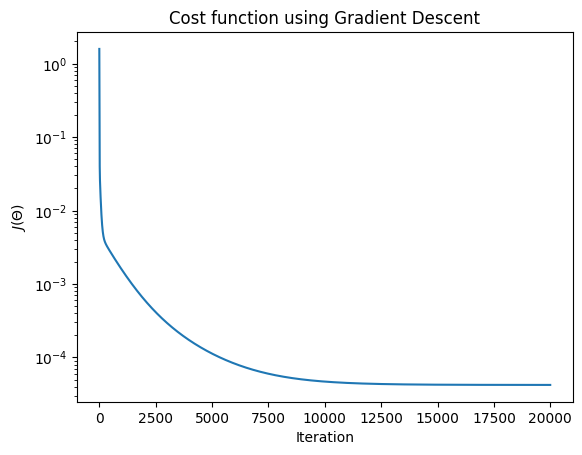

In [ ]:
alpha =0.1
n_iter = 20000
N=np.size(x,1)
theta = np.random.randn(N+1,1)
#print(theta)
x_b = np.c_[np.ones((len(x),1)),x]
#print(x_b)
print(computeCost(theta,x_b,y))

theta,cost_history,theta_history = gradient_descent(x_b,y,theta,alpha,n_iter)

print(theta)
print('Final cost/MSE:  {:0.5f}'.format(cost_history[-1]))

plt.plot(cost_history)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

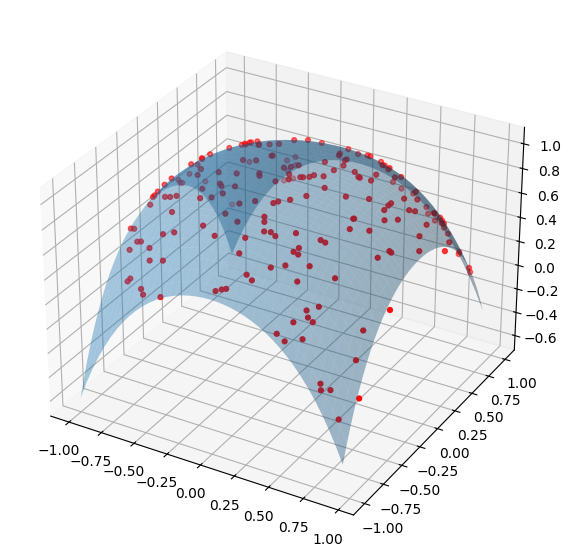

In [ ]:
[XX,YY]=np.meshgrid(df[:,1],df[:,2])
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = theta[0]+theta[1]*X**2+theta[2]*Y**2+theta[3]*X**4+theta[4]*Y**4+theta[5]*X**2*Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                        antialiased=True, alpha=0.4, label='fit result')
# Creating plot
ax.scatter3D(df[:,1],df[:,2],test_func(df[:,1],df[:,2]), color = "red", s=12, label='data sample')
# show plot
plt.show()

As shown in the result, the final cost is much smaller than that of the previous case, even though we used 1 less term to fit.